In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


rgb_paths = glob.glob("/content/drive/My Drive/ML/cell_confluency/ext_frames/*.png")

bin_paths = glob.glob("/content/drive/My Drive/ML/cell_confluency/bin_frames/*.png")
print(len(rgb_paths),len(bin_paths))

20 20


In [3]:
rgb_imgs=[]
bin_imgs=[]

width = 640
height = 368


for rgb_path, bin_path in zip(rgb_paths,bin_paths):
    tmp_rgb = cv2.imread(rgb_path, cv2.IMREAD_GRAYSCALE)
    #tmp_rgb = cv2.resize(tmp_rgb, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_NEAREST)
    tmp_rgb = cv2.resize(tmp_rgb, (width,height), interpolation=cv2.INTER_NEAREST)
    tmp_bin = cv2.imread(bin_path, cv2.IMREAD_GRAYSCALE)
    tmp_bin = cv2.resize(tmp_bin, (width,height), interpolation=cv2.INTER_NEAREST)
    rgb_imgs.append(tmp_rgb)
    bin_imgs.append(255-tmp_bin)
    
rgb_imgs = np.array(rgb_imgs)[:,:,:,np.newaxis].astype(np.float32)
bin_imgs = np.array(bin_imgs)[:,:,:,np.newaxis].astype(np.float32)
print(rgb_imgs.shape)
print(bin_imgs.shape)

(20, 368, 640, 1)
(20, 368, 640, 1)


16


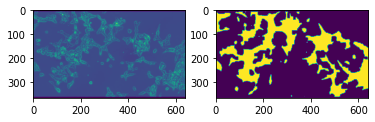

In [4]:
split = int(len(rgb_paths)*0.8)
print(split)

rgb_train=rgb_imgs[:split]
bin_train=bin_imgs[:split]

rgb_test=rgb_imgs[split:]
bin_test=bin_imgs[split:]

plt.subplot(121)
plt.imshow(rgb_train[0][:,:,0])
plt.subplot(122)
plt.imshow(bin_train[0][:,:,0])

In [5]:
#https://github.com/zhixuhao/unet/blob/master/model.py
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D,Input,UpSampling2D,concatenate,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

#https://tensorflow.classcat.com/2018/09/07/tensorflow-tutorials-images-segmentation/
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def unet(input_size = rgb_imgs.shape[1:]):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, 3, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation(tf.nn.swish)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation(tf.nn.swish)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation(tf.nn.swish)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation(tf.nn.swish)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation(tf.nn.swish)(conv5)

    up6 = Conv2D(512, 2, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    up6 = BatchNormalization()(up6)
    up6 = Activation(tf.nn.swish)(up6)
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation(tf.nn.swish)(conv6)


    up7 = Conv2D(256, 2, activation ='linear', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7 = BatchNormalization()(up7)
    up7 = Activation(tf.nn.swish)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation(tf.nn.swish)(conv7)


    up8 = Conv2D(128, 2, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8 = BatchNormalization()(up8)
    up8 = Activation(tf.nn.swish)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation(tf.nn.swish)(conv8)

    up9 = Conv2D(64, 2, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9 = BatchNormalization()(up9)
    up9 = Activation(tf.nn.swish)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation(tf.nn.swish)(conv9)


    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.compile(optimizer = Adam(lr = 0.5e-4), loss = dice_loss, metrics = ['accuracy'])
    return model

model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 368, 640, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 368, 640, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 368, 640, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 368, 640, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
#動画のSegmentationが目的なので、全期間を学習に突っ込む
#model.fit(rgb_train,bin_train,batch_size=8,epochs=300, validation_data=(rgb_test,bin_test),verbose=2)
model_path = "/content/drive/My Drive/ML/cell_confluency/cell segmentation long.h5"
if not os.path.exists(model_path):
  model.fit(rgb_imgs,bin_imgs,batch_size=8,epochs=300,verbose=2)
  model.save(model_path)
else:
  model = tf.keras.models.load_model(model_path,custom_objects={"dice_loss":dice_loss})
  model.summary()

Epoch 1/300
3/3 - 21s - loss: 0.1515 - accuracy: 0.1776
Epoch 2/300
3/3 - 4s - loss: 0.0221 - accuracy: 0.2466
Epoch 3/300
3/3 - 4s - loss: -6.4855e-02 - accuracy: 0.2518
Epoch 4/300
3/3 - 4s - loss: -1.3263e-01 - accuracy: 0.2423
Epoch 5/300
3/3 - 4s - loss: -1.9188e-01 - accuracy: 0.2260
Epoch 6/300
3/3 - 4s - loss: -2.4908e-01 - accuracy: 0.2144
Epoch 7/300
3/3 - 4s - loss: -2.7006e-01 - accuracy: 0.1930
Epoch 8/300
3/3 - 4s - loss: -3.3264e-01 - accuracy: 0.1884
Epoch 9/300
3/3 - 4s - loss: -3.6321e-01 - accuracy: 0.1740
Epoch 10/300
3/3 - 4s - loss: -3.8402e-01 - accuracy: 0.1604
Epoch 11/300
3/3 - 5s - loss: -4.0444e-01 - accuracy: 0.1460
Epoch 12/300
3/3 - 5s - loss: -4.3333e-01 - accuracy: 0.1425
Epoch 13/300
3/3 - 5s - loss: -4.5586e-01 - accuracy: 0.1367
Epoch 14/300
3/3 - 5s - loss: -4.7213e-01 - accuracy: 0.1279
Epoch 15/300
3/3 - 5s - loss: -4.8705e-01 - accuracy: 0.1311
Epoch 16/300
3/3 - 5s - loss: -5.0195e-01 - accuracy: 0.1363
Epoch 17/300
3/3 - 5s - loss: -5.1260e-01 

In [7]:
pred = model.predict(rgb_imgs)
print(pred.shape)

(20, 368, 640, 1)


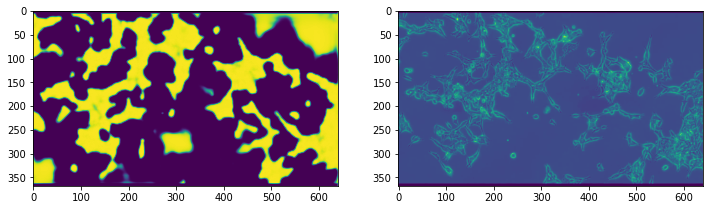

In [8]:
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(pred[0][:,:,0])
plt.subplot(122)
plt.imshow(rgb_imgs[0][:,:,0])

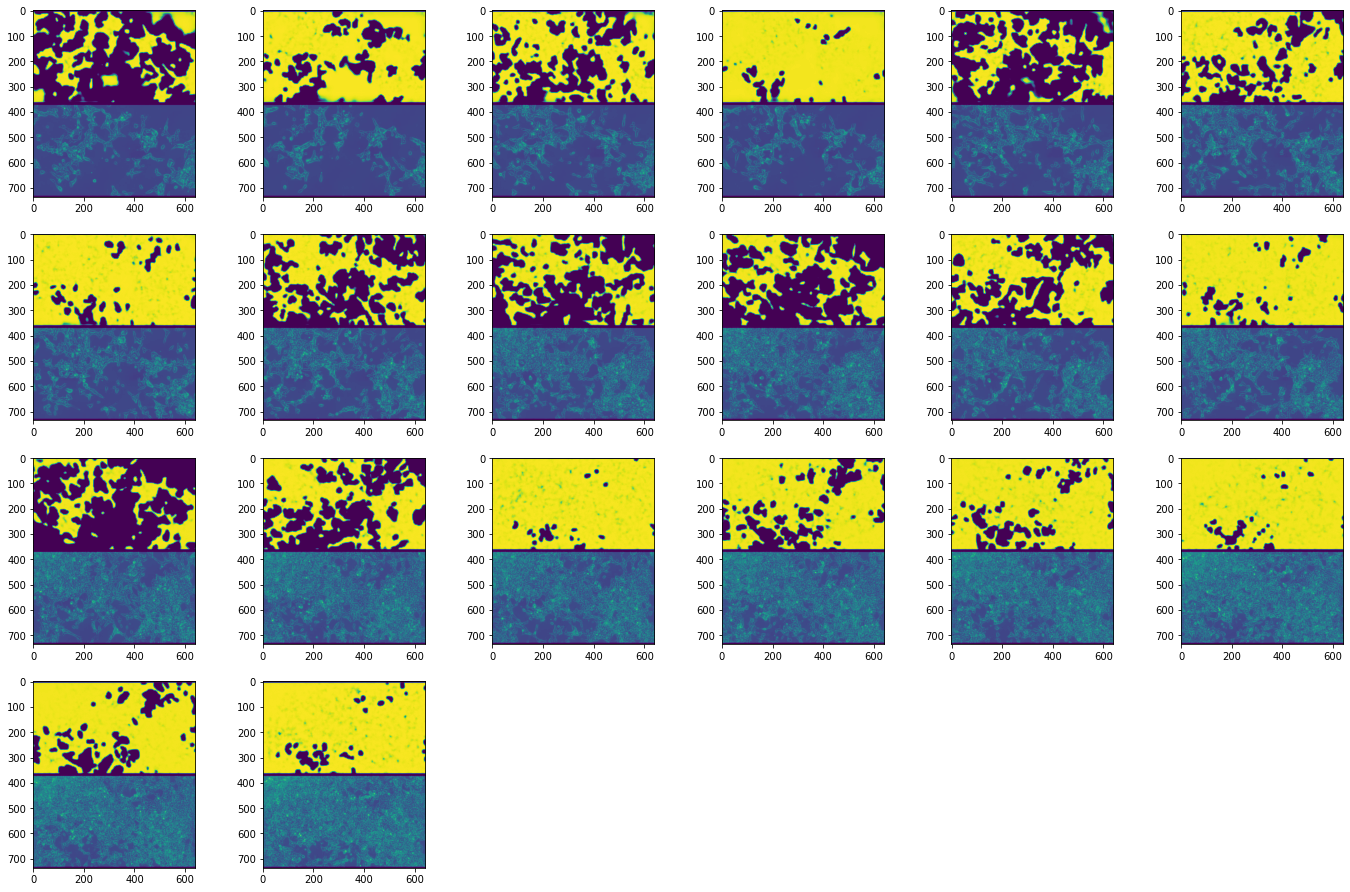

In [9]:
grid_size=6
plt.figure(figsize=(24,24))
for idx,tmp_pred in enumerate(pred):
  tmp_img = np.concatenate([tmp_pred[:,:,0]*255,rgb_imgs[idx][:,:,0]],axis=0)
  plt.subplot(grid_size,grid_size,idx+1)
  
  #plt.imshow(tmp_pred[:,:,0])
  plt.imshow(tmp_img)

In [10]:
import os

print(os.path.exists("./ZEISS Axio Observer_ HEK 293 cell culture, long-term time lapse microscopy.mp4"))
print(os.path.exists("/content/drive/My Drive/ML/cell_confluency/ZEISS Axio Observer_ HEK 293 cell culture, long-term time lapse microscopy.mp4"))
video_path = "/content/drive/My Drive/ML/cell_confluency/ZEISS Axio Observer_ HEK 293 cell culture, long-term time lapse microscopy.mp4"
print(video_path)

False
True
/content/drive/My Drive/ML/cell_confluency/ZEISS Axio Observer_ HEK 293 cell culture, long-term time lapse microscopy.mp4


In [11]:
!pip install scikit-video

In [12]:
import skvideo.io
videogen = skvideo.io.vreader(video_path)

metadata = skvideo.io.ffprobe(video_path)
frame_count = metadata["video"]['@nb_frames']
print(frame_count)

1081


In [13]:
#http://www.scikit-video.org/stable/io.html
writer = skvideo.io.FFmpegWriter("/content/drive/My Drive/ML/cell_confluency/outputvideo_concat_high.mp4")


In [14]:
count=0

for frame in videogen:

  frame = cv2.resize(frame,(rgb_imgs.shape[2],rgb_imgs.shape[1]))
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  frame = frame[np.newaxis,:,:]
  #print(frame.shape)
  pred_fr = model.predict(frame)

  #plt.imshow(pred_fr[0,:,:,0])
  #print(type(pred_fr))
  
  ori_fr = cv2.cvtColor(frame[0,:,:], cv2.COLOR_GRAY2BGR)
  pred_fr = cv2.cvtColor(pred_fr[0,:,:,0], cv2.COLOR_GRAY2BGR)*255
  pred_fr = np.concatenate([ori_fr,pred_fr],axis=0)

  pred_fr = pred_fr.astype(np.uint8)
  #print(pred_fr.dtype,pred_fr.max())
  #sys.exit()
  #print(frame.shape)
  #print(pred_fr.shape)
  #plt.imshow(pred_fr)
  writer.writeFrame(pred_fr)
  count += 1
  if count % 100 ==0:
    print(count)
    #break
  
writer.close()
print("finished")

100
200
300
400
500
600
700
800
900
1000
finished


In [15]:
!nvidia-smi

Tue Jan  5 04:09:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    34W /  70W |  14577MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------